In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.utils.data
import torch
import chess.pgn
from stockfish import Stockfish
import sqlite3

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.MSELoss()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
# model = Model()
model = torch.load('barnes1.pt')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [7]:
def fen_to_bitboard(fen):
    f = torch.zeros((12, 64))
    board = chess.Board(fen)
    if board.turn == chess.WHITE:
        a = 1
        b = -1
    if board.turn == chess.BLACK:
        a = -1
        b = 1
    f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = a
    f[1][list(board.pieces(chess.KNIGHT, chess.WHITE))] = a
    f[2][list(board.pieces(chess.ROOK, chess.WHITE))] = a
    f[3][list(board.pieces(chess.BISHOP, chess.WHITE))] = a
    f[4][list(board.pieces(chess.QUEEN, chess.WHITE))] = a
    f[5][list(board.pieces(chess.KING, chess.WHITE))] = a
    
    f[6][list(board.pieces(chess.PAWN, chess.BLACK))] = b
    f[7][list(board.pieces(chess.KNIGHT, chess.BLACK))] = b
    f[8][list(board.pieces(chess.ROOK, chess.BLACK))] = b
    f[9][list(board.pieces(chess.BISHOP, chess.BLACK))] = b
    f[10][list(board.pieces(chess.QUEEN, chess.BLACK))] = b
    f[11][list(board.pieces(chess.KING, chess.BLACK))] = b
    
    return f.view(1, 768)

In [5]:
con = sqlite3.connect('test.db')
cur = con.cursor()

In [31]:
# https://discuss.pytorch.org/t/loading-huge-data-functionality/346/3
class MyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.ids = np.arange(1, 10000)
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, id):
        fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id = {id + 1}")
        fen = fen_.fetchall()
        evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id = {id + 1}")
        evaluation = evaluation_.fetchall()
        return fen_to_bitboard(fen[0][0]), torch.tensor(evaluation[0][0], dtype=torch.float32)

# dset = MyDataset()
dset
loader = torch.utils.data.DataLoader(dset, batch_size=128, shuffle=True, num_workers=0)

In [32]:
losses = []
validation = []
running_loss = 1

In [47]:
n_epochs = 100 # or whatever

for epoch in range(n_epochs):
    for batch in loader:
        optimizer.zero_grad()
        
        train_features, train_labels = batch
        train_features = train_features.to(device)
        train_labels = train_labels.to(device)
        
        
        outputs = model(train_features.view(-1, 768))
        
        loss = loss_function(outputs, train_labels.view(-1, 1))
#         print(loss)
        running_loss = (0.9 * running_loss) + (loss * 0.1)
        losses.append(running_loss)

        loss.backward()
        optimizer.step()

In [57]:
model.eval()
fen = "r2q1rk1/ppp2ppp/2nb4/3n4/3P2b1/3BPN2/PP3PPP/R1BQ1RK1 w - - 0 10"
print(model(fen_to_bitboard(fen).to(device)))
model.train()

tensor([[0.2058]], device='cuda:0', grad_fn=<AddmmBackward0>)


Model(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [50]:
print(running_loss)

tensor(0.9258, device='cuda:0', grad_fn=<AddBackward0>)


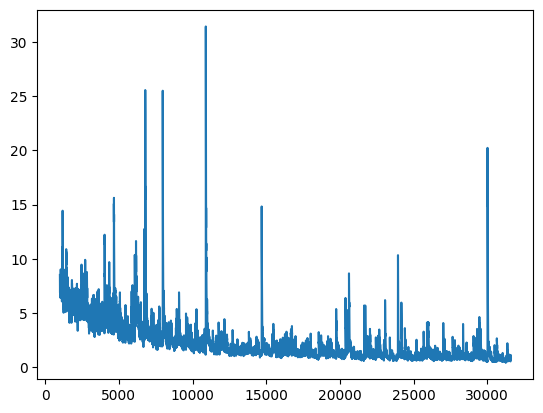

In [49]:
start = 1000
smooth = 1
x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[start:], y[start:])

In [8]:
# model eval
model.eval()
size = 10000
losses = []
fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > 1000000 LIMIT {size}")
fen = fen_.fetchall()
tensors = [fen_to_bitboard(fen[i][0]) for i in range(size)]
bits = torch.cat(tensors, dim=0)
evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > 1000000 LIMIT {size}")
evaluation = evaluation_.fetchall()
temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(size)]
evaluations = torch.tensor(temp)

n_epochs = 1 # or whatever
batch_size = 128 # or whatever

for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(bits.size()[0])
    for i in range(0, bits.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = bits[indices], evaluations[indices]
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # in case you wanted a semi-full example
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y.view(-1, 1))
        losses.append(loss)
print(sum(losses)/len(losses))
model.train()

tensor(0.0378, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


Model(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=1, bias=True)
  )
)